In [1]:
import time
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelBinarizer

In [3]:
shift = 4320

In [4]:
prefix = 'C:\\Users\\rafae\\Desktop\\Coleta\\features_hog_*.csv'

In [5]:
files_list = glob.glob(prefix)
print(len(files_list))

235


In [6]:
# read features
frames = [pd.read_csv(f, header=0) for f in files_list ]
len(frames)

235

In [7]:
ds = pd.concat(frames)

In [8]:
ds.shape

(3522, 17282)

In [9]:
ds.head()

,0,1,2,3,4,5,6,7,8,9,...,17272,17273,17274,17275,17276,17277,17278,17279,17280,17281
0,1,p002,0.024089,0.000000,0.024089,0.000012,0.024089,0.000000,0.004740,0.0,...,0.071793,0.090339,0.127822,0.127822,0.042653,0.053141,0.059538,0.003019,0.019839,0.127822
1,1,p002,0.030470,0.000000,0.030470,0.000000,0.021741,0.024379,0.007708,0.0,...,0.069514,0.119957,0.119957,0.119957,0.024254,0.051084,0.053452,0.014108,0.010533,0.119957
2,1,p002,0.034034,0.000000,0.027754,0.015728,0.028088,0.000000,0.000000,0.0,...,0.103166,0.037546,0.044686,0.122575,0.033838,0.104095,0.087389,0.003405,0.009884,0.017647
3,1,p002,0.039324,0.000000,0.036597,0.000000,0.017261,0.000000,0.024395,0.0,...,0.132490,0.091092,0.132490,0.123109,0.038147,0.132490,0.132490,0.050142,0.042432,0.028560
4,1,p002,0.029356,0.000067,0.029356,0.010806,0.029356,0.000007,0.013665,0.0,...,0.052366,0.038015,0.034714,0.061695,0.040908,0.070168,0.032586,0.004734,0.009425,0.023819


In [10]:
yData = ds['0']

In [11]:
xData = ds.iloc[:,2:2+shift+shift+shift]

In [12]:
yData.iloc[20]

10

In [13]:
print(yData.shape, xData.shape, type(yData), type(xData))

(3522,) (3522, 12960) <class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>


In [14]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn import cross_validation

# Compute confusion matrix
def plot_confusion(yTest, yTestPred, name):
    cm = confusion_matrix(yTest, yTestPred)
    np.set_printoptions(precision=2)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
    print('Classification report')
    print(classification_report(yTest, yTestPred))
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (%s)' % (name))

    plt.show()
    # plot confusion matrix

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
le = preprocessing.LabelEncoder()
le.fit(yData)
print(le.classes_)
yDataBin = le.transform(yData)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [36]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(xData, yDataBin, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,
      type(X_train.shape), type(X_test.shape), type(y_train.shape), type(y_test.shape))

(2465, 12960) (1057, 12960) (2465,) (1057,) <class 'tuple'> <class 'tuple'> <class 'tuple'> <class 'tuple'>


In [114]:
from sklearn.base import BaseEstimator, TransformerMixin
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    A feature selector for scikit-learn's Pipeline class that returns
    specified columns from a numpy array.

    """
    data = {'ir1' : [2+shift, 2+shift+shift],
            'ir2' : [2+shift+shift, 2+shift+shift+shift],
            'dep' : [2,2+shift],
            'rgb' : [1]}
    def __init__(self, key):
        print(type(key), key)
        self.key = key

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X[:, self.data[self.key][0]-1:self.data[self.key][1]]

In [115]:
from sklearn.metrics import make_scorer,precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

def search(X_train, X_test, y_train, y_test):
    
    pipe1 = Pipeline([
               ('sel', ColumnSelector(key='ir1')), # use only IR1 features
               ('clf', SVC(probability=True))])

    pipe2 = Pipeline([
               ('sel', ColumnSelector(key='dep')), # use only Depth features
               ('clf', SVC(probability=True))])
    
    pipe3 = Pipeline([
               ('sel', ColumnSelector(key='ir2')), # use only IR2 features
               ('clf', SVC(probability=True))])

    all = Pipeline([
                   ('scaler', preprocessing.StandardScaler()),
                   ('eclf', VotingClassifier(estimators=[('ir1',pipe1), ('dep',pipe2), ('ir2',pipe3)], voting='soft', weights=[2,1,2]))
    ])
    parameters = {
    'eclf__ir1__clf__C':(1.0,10,100),
    'eclf__dep__clf__C':(1.0,10,100,1000),
    #'all__ir2__clf__C':[1.0,10,100],
    }
    
    clf = GridSearchCV(all, parameters, cv=2, scoring=['f1_micro','accuracy'], refit='accuracy' , verbose = 10)
    #clf = GridSearchCV(classifier, params, cv=2, scoring=['f1_weighted','accuracy','precision_weighted', 'recall_weighted'], refit='f1_weighted' , verbose = 10)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print(clf.best_score_)
    print()
    print(clf.cv_results_.keys())
    #means = clf.cv_results_['mean_test_score']
    #stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #    print("%0.3f (+/-%0.03f) for %r"
    #          % (mean, std * 2, params))
    #print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    yTrue, yPred = y_test, clf.predict(X_test)
    print(classification_report(yTrue, yPred))
    plot_confusion(yTrue, yPred, "test")
    print()

<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
Fitting 2 folds for each of 12 candidates, totalling 24 fits
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=1.0, eclf__ir1__clf__C=1.0 ....................
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=1.0, eclf__ir1__clf__C=1.0, f1_micro=0.7907915993537964, accuracy=0.7907915993537964, total= 5.4min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=1.0, eclf__ir1__clf__C=1.0 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min remaining:    0.0s


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=1.0, eclf__ir1__clf__C=1.0, f1_micro=0.7881010594947025, accuracy=0.7881010594947025, total= 5.3min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=1.0, eclf__ir1__clf__C=10 .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.7min remaining:    0.0s


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=1.0, eclf__ir1__clf__C=10, f1_micro=0.8602584814216478, accuracy=0.8602584814216478, total= 5.3min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=1.0, eclf__ir1__clf__C=10 .....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.0min remaining:    0.0s


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=1.0, eclf__ir1__clf__C=10, f1_micro=0.8622656886715566, accuracy=0.8622656886715566, total= 5.3min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=1.0, eclf__ir1__clf__C=100 ....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 25.3min remaining:    0.0s


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=1.0, eclf__ir1__clf__C=100, f1_micro=0.858642972536349, accuracy=0.8586429725363489, total= 5.3min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=1.0, eclf__ir1__clf__C=100 ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 31.5min remaining:    0.0s


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=1.0, eclf__ir1__clf__C=100, f1_micro=0.8655256723716381, accuracy=0.8655256723716381, total= 5.3min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=10, eclf__ir1__clf__C=1.0 .....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 37.8min remaining:    0.0s


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=10, eclf__ir1__clf__C=1.0, f1_micro=0.8037156704361873, accuracy=0.8037156704361874, total= 5.3min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=10, eclf__ir1__clf__C=1.0 .....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 44.1min remaining:    0.0s


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=10, eclf__ir1__clf__C=1.0, f1_micro=0.8092909535452323, accuracy=0.8092909535452323, total= 5.4min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=10, eclf__ir1__clf__C=10 ......................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 50.5min remaining:    0.0s


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=10, eclf__ir1__clf__C=10, f1_micro=0.8667205169628432, accuracy=0.8667205169628432, total= 5.3min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=10, eclf__ir1__clf__C=10 ......................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 56.8min remaining:    0.0s


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=10, eclf__ir1__clf__C=10, f1_micro=0.8712306438467807, accuracy=0.8712306438467807, total= 5.7min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=10, eclf__ir1__clf__C=100 .....................
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=10, eclf__ir1__clf__C=100, f1_micro=0.8659127625201939, accuracy=0.8659127625201939, total= 5.5min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=10, eclf__ir1__clf__C=100 .....................
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=10, eclf__ir1__clf__C=100, f1_micro=0.8712306438467807, accuracy=0.8712306438467807, total= 5.3min
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV] eclf__dep__clf__C=100, eclf__ir1__clf__C=1.0 ....................
<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
[CV]  eclf__dep__clf__C=100, eclf__ir1__c

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 154.0min finished


<class 'str'> ir1
<class 'str'> dep
<class 'str'> ir2
Best parameters set found on development set:

{'eclf__dep__clf__C': 100, 'eclf__ir1__clf__C': 10}

Grid scores on development set:
0.870588235294

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_eclf__dep__clf__C', 'param_eclf__ir1__clf__C', 'params', 'split0_test_f1_micro', 'split1_test_f1_micro', 'mean_test_f1_micro', 'std_test_f1_micro', 'rank_test_f1_micro', 'split0_train_f1_micro', 'split1_train_f1_micro', 'mean_train_f1_micro', 'std_train_f1_micro', 'split0_test_accuracy', 'split1_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy', 'split1_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy'])
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.95      0.91      0.93    

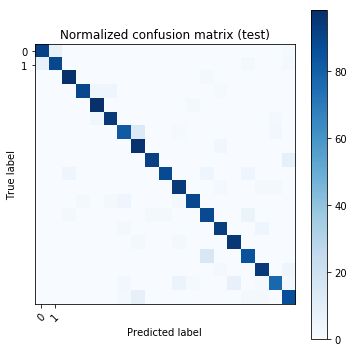

In [116]:
search(X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(nds.iloc[:,2:])
nnds = pca.transform(nds.iloc[:,2:])

In [ ]:
from sklearn.metrics import make_scorer,precision_recall_fscore_support

def search2(X_train, X_test, y_train, y_test):
    
    # normalize data
    print("Normalizing data!")
    #stdScale = preprocessing.StandardScaler().fit(xTrain)
    #xTrain = stdScale.transform(xTrain)
    #xTest = stdScale.transform(xTest)
    
    print("Grid Search Classifiers!")
    
    knc = KNeighborsClassifier()
    svc = SVC()
    rfc = RandomForestClassifier()
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    clf1 = SVC()
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    vt = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

    kncp = [{'n_neighbors': [3, 5, 7],
             'weights': ['uniform','distance'],
              'algorithm': ['auto','ball_tree', 'kd_tree', 'brute']}]
    svcp = [{'kernel': ['rbf','linear'], 
             'gamma': [1e-3, 1e-4],
             'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 1, 10, 100, 1000]}]
    rfcp = [{'n_estimators': [10, 20, 50, 100,200,300], 
            'max_depth': [None, 1, 10, 100],
            'bootstrap': [True, False],
            'criterion': ["gini", "entropy"]}]
    gbp = [{#'loss' : ['deviance', 'exponential'],
           'n_estimators': [50,100],
           'learning_rate': [0.1,1.0,10],
           'max_depth' : [3,5,10]
            }]
           #'min_impurity_decrease': [0.0]}]#, 0.1]}]
    vtp = [{'svc__C': [1.0, 100.0], 
            'rf__n_estimators': [20, 200],}]
   
    classifiers = [#('kNN', knc, kncp),                                 
                    #('Support Vector', svc, svcp),
                    #('Random Forest', rfc, rfcp),
                    ('Gradient Boosting', gb, gbp),
                    ('Vooting', vt, vtp)]
    
    for name, classifier, params in classifiers:
        print(name)
        clf = GridSearchCV(classifier, params, cv=2, scoring=['f1_weighted','accuracy','precision_weighted', 'recall_weighted'], refit='f1_weighted' , verbose = 10)

        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print(clf.best_score_)
        print()
        print(clf.cv_results_.keys())
        #means = clf.cv_results_['mean_test_score']
        #stds = clf.cv_results_['std_test_score']
        #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #    print("%0.3f (+/-%0.03f) for %r"
        #          % (mean, std * 2, params))
        #print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        yTrue, yPred = y_test, clf.predict(X_test)
        print(classification_report(yTrue, yPred))
        plot_confusion(yTrue, yPred, name)
        print()